In [1]:
cd /data/projects/windturbine-identification/MachineLearningCourse

/data/projects/windturbine-identification/MachineLearningCourse


In [2]:
# -*- coding: utf-8 -*-
"""
Created on Mon Feb 18 13:04:17 2019

@author: jschmidt
"""
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

import pickle  # pip install dill --user
import matplotlib.pyplot as plt
from keras.applications import VGG16
import tensorflow as tf

import imp
import scripts.windturbines.functions_pattern_recognition as fpr
imp.reload(fpr)

gpu_fraction = 0.8
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=gpu_fraction)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))


Using TensorFlow backend.


# Training Phase

In [3]:
COUNTRY = "MIX"

t_base_dir = fpr.get_param(COUNTRY, "PATH_ML_IMAGES_TURBINES_TRAIN") + "../"

v_base_dir = fpr.get_param(COUNTRY,
                           "PATH_ML_IMAGES_TURBINES_VALIDATION") + "../"

test_base_dir = fpr.get_param(COUNTRY, "PATH_ML_IMAGES_TURBINES_TEST") + "../"

# Part II: Pretrained model


conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(256, 256, 3))

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block4_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        t_base_dir,
        # All images will be resized to 150x150
        # target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        v_base_dir,
        # target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

mcp_save = ModelCheckpoint('models/model-{epoch:04d}-{val_loss:.4f}.h5',
                           save_best_only=True, monitor='val_loss', mode='min')

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      callbacks=[mcp_save],
      verbose=2)



Instructions for updating:
Colocations handled automatically by placer.
Found 7996 images belonging to 2 classes.
Found 1712 images belonging to 2 classes.
Instructions for updating:
Use tf.cast instead.
Epoch 1/30
 - 39s - loss: 0.3156 - acc: 0.8595 - val_loss: 0.1022 - val_acc: 0.9680
Epoch 2/30
 - 36s - loss: 0.1476 - acc: 0.9430 - val_loss: 0.0667 - val_acc: 0.9869
Epoch 3/30
 - 36s - loss: 0.1070 - acc: 0.9645 - val_loss: 0.0484 - val_acc: 0.9920
Epoch 4/30
 - 37s - loss: 0.1170 - acc: 0.9669 - val_loss: 0.0516 - val_acc: 0.9869
Epoch 5/30
 - 36s - loss: 0.0972 - acc: 0.9665 - val_loss: 0.0191 - val_acc: 0.9920
Epoch 6/30
 - 36s - loss: 0.0892 - acc: 0.9695 - val_loss: 0.0464 - val_acc: 0.9950
Epoch 7/30
 - 36s - loss: 0.0971 - acc: 0.9665 - val_loss: 0.0632 - val_acc: 0.9849
Epoch 8/30
 - 36s - loss: 0.0863 - acc: 0.9765 - val_loss: 0.0806 - val_acc: 0.9870
Epoch 9/30
 - 36s - loss: 0.0936 - acc: 0.9715 - val_loss: 0.0387 - val_acc: 0.9929
Epoch 10/30
 - 36s - loss: 0.0625 - acc:

# Validation vs. Training

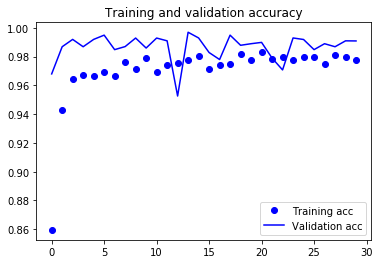

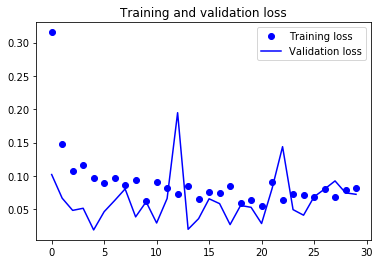

In [4]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()




# Model selection

In [5]:
min_val_loss = min(val_loss)

i = val_loss.index(min_val_loss) + 1

best_model = "models/model-" + "{0:0=4d}".format(i) + "-" + "{0:.4f}".format(min_val_loss) + ".h5"

best_model


'models/model-0005-0.0191.h5'

# Test

In [6]:
test_base_dir=fpr.get_param(COUNTRY, "PATH_ML_IMAGES_TURBINES_TEST")+"../"

test_model = models.load_model(best_model)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        test_base_dir,
        target_size=(256, 256),
        batch_size=32,
        class_mode='binary')

test_loss, test_acc = test_model.evaluate_generator(test_generator, steps=32)
print('test acc:', test_acc)
print('test loss:', test_loss)


Found 1690 images belonging to 2 classes.
test acc: 0.986328125
test loss: 0.05518102074120179
